# Deep learning with ICCD images of plasma plumes generated during pulsed laser deposition for growth kinetics prediction - MLP Model

#### Sumner B. Harris

This notebook is designed to provide a functional example of using an MLP for growth kinetics prediction during pulsed laser deposition (PLD).

Start by importing the required packages:

In [1]:
# Import some basics
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Import our custom modules
import ICCDutils
import models

# Import Torch stuff
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

## Define the dataset class

In [2]:
class PLDdataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform, target_params, augment=True):
        self.df = dataframe
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get growth parameters
        params = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'T'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        
        # get targets
        if target_params == 'anomaly':
            target = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        if target_params == 'growth':
            target = torch.tensor([self.df.loc[idx,'s0'],self.df.loc[idx,'s1'],self.df.loc[idx,'J']],dtype=torch.float32)

        # get ICCD image sequence
        image1 = torch.tensor(self.df.loc[idx,'ICCD'],dtype=torch.float32)

        if self.augment:
            image1 = self.transform(image1)      
            # add measurement noise to parameters for augmentation
            params[0] = params[0] + torch.randn(1)*2*np.sqrt(params[0]*0.00125) # account for 2 sigma, 0.25% baratron accuracy
            params[1] = params[1] + torch.randn(1)*2*np.sqrt(params[1]*0.0075)# account for 2 sigma, 1.5% temperature
            params[2] = params[2] + torch.randn(1)*2*np.sqrt(params[2]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy
            params[3] = params[3] + torch.randn(1)*2*np.sqrt(params[3]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy

        return image1, params, target

## Make a helper function to load the data and split into training and validation sets

In [3]:
def load_data(datafile, target_params, normalize_PTE1E2, train_percent=70):
    # Create a transform for the ICCD images
    transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
    
    # load the full data from the json file
    df = ICCDutils.load_df(datafile, normalize_PTE1E2=normalize_PTE1E2)
    
    train_number = int(len(df)*train_percent/100)
    val_number = len(df)-train_number
    print('Total number of samples: {}'.format(len(df)))
    print('Number of training samples: {}\nNumber of validation samples: {}'.format(train_number, val_number))
    
    # instantiate the PLDdataset class
    dataset = PLDdataset(df, transform, target_params)
    
    # set a seed for reproducibility
    generator = torch.Generator().manual_seed(42)
    
    # randomly split the data into training and validation sets
    train_data, val_data = random_split(dataset,[train_number,val_number],generator=generator)
    
    return train_data, val_data

# Define the training function

In [7]:
def model_train_best(config, target_params, normalize_PTE1E2, chk_name):
    train_loss_list = []
    test_loss_list = []
    r2_list = []
    print("I'M TRAINING, I'M TRAINING!!")
    model = models.MLP(param_l1=config['param_l1'],param_out=config['param_out'])
    
    device = 'cpu'
    if torch.cuda.is_available():
        print('Using GPU.')
        device = "cuda:0"    
        if torch.cuda.device_count() > 1:
            print('Using multiple GPUs.')
            model = nn.DataParallel(model)
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=config['lr'],amsgrad=True,weight_decay=config['weight_decay'])
    
    BATCH_SIZE = 88
    train_data, val_data = load_data(datafile,target_params,normalize_PTE1E2, train_percent=70)
    
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

    #print('Total image feature params:',sum(p.numel() for p in model.ICCD_features_.parameters()))
    #print('Total model params:',sum(p.numel() for p in model.parameters()))

    loss_values = []
    val_loss_values = []
    best_R2 = 0.0
    n_epochs=2000
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for id_batch, (image1,params,target) in enumerate(train_loader):
            params=params.to(device)
            score = target.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(params)
            loss = loss_fn(y_pred, score)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_values.append(loss_train/len(train_loader))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                                                          loss_train / len(train_loader)))
        
        train_pred, train_actuals = y_pred.cpu(), score.cpu()
        size = len(val_loader.dataset)
        num_batches = len(val_loader)
        test_loss = 0.0
        train_loss_list.append(loss_train)
        
        for (image1,params,target) in val_loader:
            with torch.no_grad():
                params=params.to(device)
                score = target.to(device)
                pred = model(params)
                test_loss += loss_fn(pred, score).item()
                pr2 = pearsonr(score[:,0].cpu(), pred[:,0].cpu())[0]**2
                e1r2 = pearsonr(score[:,1].cpu(), pred[:,1].cpu())[0]**2
                e2r2 = pearsonr(score[:,2].cpu(), pred[:,2].cpu())[0]**2
                meanR2 = np.array([pr2,e1r2,e2r2]).mean()
                print('R2 values {:.4f}, {:.4f}, {:.4f}; mean R2={:.4f}'.format(pr2, e1r2, e2r2, meanR2))
                r2_list.append([pr2, e1r2, e2r2,meanR2])
                
        if meanR2>best_R2:
            print('New best, saving checkpoint...')
            best_R2 = meanR2
            best_val_predictions, best_val_actuals = pred.cpu().detach(), score.cpu().detach()
            best_train_predictions, best_train_actuals = train_pred.cpu().detach(), train_actuals.cpu().detach()
            
            torch.save(model.state_dict(), 'Model Checkpoints/MLP_l1-{:.4f}_l2-{:.4f}_lr-{:.4f}_L2-{:.4f}.model'.format(config['param_l1'],config['param_out'], config['lr'],config['weight_decay']))
        test_loss /= num_batches
        test_loss_list.append(test_loss)
        val_loss_values.append(test_loss)
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        
    return best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals

## Set up the configuration and train the model

In [8]:
config = {
        'param_l1': 48,
        'param_out': 32,
        'lr': 0.011161751166183152,
        'weight_decay': 0.00027243494911370175
}

datafile = 'PLD data.json'
target_params = 'growth'
normalize_PTE1E2 = True
chk_name = 'MLP'

BATCH_SIZE = 88

best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals = model_train_best(config, target_params, normalize_PTE1E2, chk_name)

I'M TRAINING, I'M TRAINING!!
Using GPU.
Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39
2023-11-16 14:17:15.851969 Epoch 1, Training loss 24.670278549194336
R2 values 0.0013, 0.0214, 0.0062; mean R2=0.0096
New best, saving checkpoint...
Test Error: Avg loss: 27.223618 

2023-11-16 14:17:16.114368 Epoch 2, Training loss 23.6546573638916
R2 values 0.0007, 0.0922, 0.0959; mean R2=0.0630
New best, saving checkpoint...
Test Error: Avg loss: 26.026892 

2023-11-16 14:17:16.356961 Epoch 3, Training loss 22.592397689819336
R2 values 0.0000, 0.0488, 0.0233; mean R2=0.0240
Test Error: Avg loss: 24.581930 

2023-11-16 14:17:16.601883 Epoch 4, Training loss 21.296201705932617
R2 values 0.0004, 0.0895, 0.0057; mean R2=0.0319
Test Error: Avg loss: 22.837959 

2023-11-16 14:17:16.845505 Epoch 5, Training loss 19.828920364379883
R2 values 0.0034, 0.0098, 0.0433; mean R2=0.0188
Test Error: Avg loss: 20.888971 

2023-11-16 14:17:17.090264 Epoch 6, Training lo

2023-11-16 14:17:28.355882 Epoch 52, Training loss 4.281654357910156
R2 values 0.5956, 0.6375, 0.6739; mean R2=0.6356
Test Error: Avg loss: 5.022687 

2023-11-16 14:17:28.602653 Epoch 53, Training loss 4.906689643859863
R2 values 0.5438, 0.6139, 0.6269; mean R2=0.5949
Test Error: Avg loss: 5.083211 

2023-11-16 14:17:28.849544 Epoch 54, Training loss 4.429980278015137
R2 values 0.5001, 0.6366, 0.6507; mean R2=0.5958
Test Error: Avg loss: 5.082293 

2023-11-16 14:17:29.095049 Epoch 55, Training loss 5.143357753753662
R2 values 0.5871, 0.7326, 0.7002; mean R2=0.6733
New best, saving checkpoint...
Test Error: Avg loss: 4.079105 

2023-11-16 14:17:29.340190 Epoch 56, Training loss 5.386952877044678
R2 values 0.5286, 0.6686, 0.6879; mean R2=0.6284
Test Error: Avg loss: 4.492390 

2023-11-16 14:17:29.587120 Epoch 57, Training loss 5.140900611877441
R2 values 0.6304, 0.5732, 0.6417; mean R2=0.6151
Test Error: Avg loss: 5.339903 

2023-11-16 14:17:29.836425 Epoch 58, Training loss 4.5243196487

2023-11-16 14:17:41.414050 Epoch 106, Training loss 4.824821949005127
R2 values 0.5733, 0.7588, 0.7141; mean R2=0.6820
New best, saving checkpoint...
Test Error: Avg loss: 3.728050 

2023-11-16 14:17:41.658824 Epoch 107, Training loss 5.11684513092041
R2 values 0.6109, 0.5442, 0.6230; mean R2=0.5927
Test Error: Avg loss: 5.558784 

2023-11-16 14:17:41.903741 Epoch 108, Training loss 4.506682395935059
R2 values 0.4913, 0.6585, 0.6477; mean R2=0.5992
Test Error: Avg loss: 4.755772 

2023-11-16 14:17:42.144296 Epoch 109, Training loss 4.716058254241943
R2 values 0.5722, 0.5899, 0.5828; mean R2=0.5816
Test Error: Avg loss: 5.593601 

2023-11-16 14:17:42.388873 Epoch 110, Training loss 5.184262752532959
R2 values 0.6348, 0.7268, 0.6676; mean R2=0.6764
Test Error: Avg loss: 3.869635 

2023-11-16 14:17:42.635582 Epoch 111, Training loss 4.840456962585449
R2 values 0.4036, 0.6311, 0.5569; mean R2=0.5305
Test Error: Avg loss: 5.334083 

2023-11-16 14:17:42.878630 Epoch 112, Training loss 4.6270

2023-11-16 14:17:54.511760 Epoch 160, Training loss 5.1081109046936035
R2 values 0.6094, 0.7351, 0.7967; mean R2=0.7137
New best, saving checkpoint...
Test Error: Avg loss: 4.517328 

2023-11-16 14:17:54.749494 Epoch 161, Training loss 3.641258955001831
R2 values 0.5691, 0.8401, 0.6484; mean R2=0.6859
Test Error: Avg loss: 3.415562 

2023-11-16 14:17:54.992950 Epoch 162, Training loss 4.9960150718688965
R2 values 0.5428, 0.5837, 0.5044; mean R2=0.5436
Test Error: Avg loss: 6.114549 

2023-11-16 14:17:55.235630 Epoch 163, Training loss 5.069795608520508
R2 values 0.5126, 0.5319, 0.6380; mean R2=0.5608
Test Error: Avg loss: 6.222109 

2023-11-16 14:17:55.473785 Epoch 164, Training loss 4.521251201629639
R2 values 0.5913, 0.4740, 0.5406; mean R2=0.5353
Test Error: Avg loss: 6.597708 

2023-11-16 14:17:55.714298 Epoch 165, Training loss 5.081959247589111
R2 values 0.7133, 0.6378, 0.6214; mean R2=0.6575
Test Error: Avg loss: 4.645132 

2023-11-16 14:17:55.952669 Epoch 166, Training loss 4.6

2023-11-16 14:18:08.264268 Epoch 214, Training loss 5.484830856323242
R2 values 0.6069, 0.6258, 0.6389; mean R2=0.6239
Test Error: Avg loss: 4.885826 

2023-11-16 14:18:08.502445 Epoch 215, Training loss 4.012947082519531
R2 values 0.6548, 0.7937, 0.6189; mean R2=0.6891
Test Error: Avg loss: 3.992659 

2023-11-16 14:18:08.741012 Epoch 216, Training loss 4.353209018707275
R2 values 0.5530, 0.6342, 0.6214; mean R2=0.6028
Test Error: Avg loss: 5.515617 

2023-11-16 14:18:08.981049 Epoch 217, Training loss 4.074774742126465
R2 values 0.5485, 0.6448, 0.6830; mean R2=0.6255
Test Error: Avg loss: 4.805896 

2023-11-16 14:18:09.221566 Epoch 218, Training loss 3.5690197944641113
R2 values 0.6233, 0.7434, 0.7203; mean R2=0.6957
Test Error: Avg loss: 3.663837 

2023-11-16 14:18:09.458905 Epoch 219, Training loss 4.459108829498291
R2 values 0.4747, 0.6583, 0.5765; mean R2=0.5698
Test Error: Avg loss: 5.098081 

2023-11-16 14:18:09.698509 Epoch 220, Training loss 3.211344003677368
R2 values 0.5864,

2023-11-16 14:18:21.130118 Epoch 268, Training loss 4.010899066925049
R2 values 0.5702, 0.6457, 0.4981; mean R2=0.5713
Test Error: Avg loss: 5.132803 

2023-11-16 14:18:21.366280 Epoch 269, Training loss 4.986091136932373
R2 values 0.6125, 0.6778, 0.5864; mean R2=0.6256
Test Error: Avg loss: 4.648592 

2023-11-16 14:18:21.603474 Epoch 270, Training loss 3.331005811691284
R2 values 0.5442, 0.6991, 0.6840; mean R2=0.6424
Test Error: Avg loss: 4.447220 

2023-11-16 14:18:21.842498 Epoch 271, Training loss 4.208950996398926
R2 values 0.6201, 0.6330, 0.6601; mean R2=0.6377
Test Error: Avg loss: 5.270237 

2023-11-16 14:18:22.084925 Epoch 272, Training loss 4.508360862731934
R2 values 0.7136, 0.6550, 0.6665; mean R2=0.6783
Test Error: Avg loss: 4.332973 

2023-11-16 14:18:22.329010 Epoch 273, Training loss 4.193521499633789
R2 values 0.5003, 0.6766, 0.5040; mean R2=0.5603
Test Error: Avg loss: 5.657488 

2023-11-16 14:18:22.568652 Epoch 274, Training loss 4.689022541046143
R2 values 0.5288, 

2023-11-16 14:18:34.027240 Epoch 322, Training loss 4.520564556121826
R2 values 0.6268, 0.7848, 0.6642; mean R2=0.6919
Test Error: Avg loss: 3.544951 

2023-11-16 14:18:34.267152 Epoch 323, Training loss 3.844951868057251
R2 values 0.6430, 0.7771, 0.7171; mean R2=0.7124
Test Error: Avg loss: 3.524421 

2023-11-16 14:18:34.500859 Epoch 324, Training loss 3.502552032470703
R2 values 0.5515, 0.7798, 0.6138; mean R2=0.6484
Test Error: Avg loss: 3.672487 

2023-11-16 14:18:34.735561 Epoch 325, Training loss 3.149505615234375
R2 values 0.6153, 0.7785, 0.6967; mean R2=0.6969
Test Error: Avg loss: 3.472791 

2023-11-16 14:18:34.974762 Epoch 326, Training loss 4.045851230621338
R2 values 0.5682, 0.8491, 0.7425; mean R2=0.7199
Test Error: Avg loss: 3.192512 

2023-11-16 14:18:35.215410 Epoch 327, Training loss 4.582010269165039
R2 values 0.6189, 0.6657, 0.6584; mean R2=0.6476
Test Error: Avg loss: 4.926979 

2023-11-16 14:18:35.457718 Epoch 328, Training loss 4.413044452667236
R2 values 0.4597, 

2023-11-16 14:18:47.593717 Epoch 376, Training loss 3.447869062423706
R2 values 0.6437, 0.7150, 0.6796; mean R2=0.6794
Test Error: Avg loss: 4.192471 

2023-11-16 14:18:47.830295 Epoch 377, Training loss 3.302558183670044
R2 values 0.6588, 0.6885, 0.6584; mean R2=0.6686
Test Error: Avg loss: 4.776780 

2023-11-16 14:18:48.068874 Epoch 378, Training loss 3.7366230487823486
R2 values 0.6901, 0.8521, 0.6334; mean R2=0.7252
Test Error: Avg loss: 2.963593 

2023-11-16 14:18:48.301198 Epoch 379, Training loss 4.052072525024414
R2 values 0.6778, 0.7912, 0.6861; mean R2=0.7184
Test Error: Avg loss: 3.104847 

2023-11-16 14:18:48.536844 Epoch 380, Training loss 3.678187370300293
R2 values 0.4376, 0.4902, 0.5654; mean R2=0.4977
Test Error: Avg loss: 6.733705 

2023-11-16 14:18:48.774897 Epoch 381, Training loss 3.749084234237671
R2 values 0.6297, 0.6975, 0.6713; mean R2=0.6662
Test Error: Avg loss: 4.481882 

2023-11-16 14:18:49.015079 Epoch 382, Training loss 4.561723232269287
R2 values 0.6873,

2023-11-16 14:19:00.529324 Epoch 430, Training loss 3.6146738529205322
R2 values 0.7593, 0.7491, 0.6867; mean R2=0.7317
Test Error: Avg loss: 3.468980 

2023-11-16 14:19:00.773831 Epoch 431, Training loss 3.493267297744751
R2 values 0.5936, 0.8224, 0.6643; mean R2=0.6934
Test Error: Avg loss: 3.682111 

2023-11-16 14:19:01.018786 Epoch 432, Training loss 3.117072343826294
R2 values 0.6901, 0.8254, 0.6290; mean R2=0.7149
Test Error: Avg loss: 3.055968 

2023-11-16 14:19:01.258030 Epoch 433, Training loss 4.355136394500732
R2 values 0.7433, 0.7904, 0.7231; mean R2=0.7523
Test Error: Avg loss: 3.063056 

2023-11-16 14:19:01.497909 Epoch 434, Training loss 3.6192495822906494
R2 values 0.7212, 0.7790, 0.7477; mean R2=0.7493
Test Error: Avg loss: 3.171618 

2023-11-16 14:19:01.734941 Epoch 435, Training loss 3.599123954772949
R2 values 0.7041, 0.7495, 0.7902; mean R2=0.7479
Test Error: Avg loss: 3.195585 

2023-11-16 14:19:01.973256 Epoch 436, Training loss 4.299287796020508
R2 values 0.6322

2023-11-16 14:19:13.703393 Epoch 484, Training loss 4.788582801818848
R2 values 0.6623, 0.5180, 0.5658; mean R2=0.5820
Test Error: Avg loss: 6.051842 

2023-11-16 14:19:13.957060 Epoch 485, Training loss 4.920455455780029
R2 values 0.6493, 0.7941, 0.6410; mean R2=0.6948
Test Error: Avg loss: 3.560740 

2023-11-16 14:19:14.207469 Epoch 486, Training loss 3.7120041847229004
R2 values 0.6892, 0.7660, 0.7131; mean R2=0.7227
Test Error: Avg loss: 4.019280 

2023-11-16 14:19:14.457465 Epoch 487, Training loss 4.1095452308654785
R2 values 0.5722, 0.6844, 0.6134; mean R2=0.6233
Test Error: Avg loss: 5.122300 

2023-11-16 14:19:14.701432 Epoch 488, Training loss 3.769670248031616
R2 values 0.6788, 0.6451, 0.6415; mean R2=0.6551
Test Error: Avg loss: 4.798953 

2023-11-16 14:19:14.942750 Epoch 489, Training loss 3.435429573059082
R2 values 0.6247, 0.6680, 0.7393; mean R2=0.6773
Test Error: Avg loss: 4.205317 

2023-11-16 14:19:15.187908 Epoch 490, Training loss 4.004773139953613
R2 values 0.6737

2023-11-16 14:19:27.165624 Epoch 538, Training loss 4.357424736022949
R2 values 0.6634, 0.8156, 0.6276; mean R2=0.7022
Test Error: Avg loss: 3.271231 

2023-11-16 14:19:27.418018 Epoch 539, Training loss 3.970419406890869
R2 values 0.6967, 0.5819, 0.6205; mean R2=0.6330
Test Error: Avg loss: 5.400047 

2023-11-16 14:19:27.675009 Epoch 540, Training loss 4.0213751792907715
R2 values 0.6308, 0.8152, 0.6954; mean R2=0.7138
Test Error: Avg loss: 3.494360 

2023-11-16 14:19:27.934094 Epoch 541, Training loss 3.510077714920044
R2 values 0.7037, 0.7959, 0.6606; mean R2=0.7201
Test Error: Avg loss: 3.223012 

2023-11-16 14:19:28.177497 Epoch 542, Training loss 3.868447780609131
R2 values 0.6538, 0.8072, 0.6396; mean R2=0.7002
Test Error: Avg loss: 3.123254 

2023-11-16 14:19:28.433472 Epoch 543, Training loss 2.9051549434661865
R2 values 0.6617, 0.7463, 0.6788; mean R2=0.6956
Test Error: Avg loss: 3.665828 

2023-11-16 14:19:28.692525 Epoch 544, Training loss 3.736598253250122
R2 values 0.6962

2023-11-16 14:19:40.643471 Epoch 592, Training loss 3.442131519317627
R2 values 0.7119, 0.8290, 0.7150; mean R2=0.7520
Test Error: Avg loss: 3.328248 

2023-11-16 14:19:40.902386 Epoch 593, Training loss 4.631840229034424
R2 values 0.6750, 0.7873, 0.6790; mean R2=0.7138
Test Error: Avg loss: 3.358031 

2023-11-16 14:19:41.152142 Epoch 594, Training loss 3.1491239070892334
R2 values 0.6856, 0.6683, 0.6141; mean R2=0.6560
Test Error: Avg loss: 4.589120 

2023-11-16 14:19:41.392457 Epoch 595, Training loss 3.6060948371887207
R2 values 0.7496, 0.8093, 0.7328; mean R2=0.7639
Test Error: Avg loss: 2.885800 

2023-11-16 14:19:41.642691 Epoch 596, Training loss 5.313765048980713
R2 values 0.7425, 0.7666, 0.8125; mean R2=0.7739
Test Error: Avg loss: 3.157578 

2023-11-16 14:19:41.891764 Epoch 597, Training loss 3.4318745136260986
R2 values 0.6930, 0.6614, 0.7069; mean R2=0.6871
Test Error: Avg loss: 4.352868 

2023-11-16 14:19:42.142801 Epoch 598, Training loss 4.52606725692749
R2 values 0.7022

2023-11-16 14:19:54.041069 Epoch 646, Training loss 3.878676652908325
R2 values 0.7526, 0.7980, 0.6427; mean R2=0.7311
Test Error: Avg loss: 3.298965 

2023-11-16 14:19:54.291398 Epoch 647, Training loss 3.3224096298217773
R2 values 0.7064, 0.7914, 0.7245; mean R2=0.7408
Test Error: Avg loss: 3.022197 

2023-11-16 14:19:54.532128 Epoch 648, Training loss 3.545400857925415
R2 values 0.7198, 0.6666, 0.6808; mean R2=0.6891
Test Error: Avg loss: 4.313435 

2023-11-16 14:19:54.778464 Epoch 649, Training loss 4.238964080810547
R2 values 0.7778, 0.8139, 0.7370; mean R2=0.7762
Test Error: Avg loss: 3.382497 

2023-11-16 14:19:55.025053 Epoch 650, Training loss 4.481673717498779
R2 values 0.6589, 0.7052, 0.7473; mean R2=0.7038
Test Error: Avg loss: 3.924925 

2023-11-16 14:19:55.276134 Epoch 651, Training loss 4.236513137817383
R2 values 0.4656, 0.5487, 0.4787; mean R2=0.4977
Test Error: Avg loss: 6.679961 

2023-11-16 14:19:55.525716 Epoch 652, Training loss 4.417538166046143
R2 values 0.7211,

2023-11-16 14:20:07.942168 Epoch 700, Training loss 3.3900017738342285
R2 values 0.6468, 0.7004, 0.7102; mean R2=0.6858
Test Error: Avg loss: 3.990293 

2023-11-16 14:20:08.179288 Epoch 701, Training loss 3.186131000518799
R2 values 0.7442, 0.6752, 0.7186; mean R2=0.7127
Test Error: Avg loss: 4.061769 

2023-11-16 14:20:08.434686 Epoch 702, Training loss 2.9489586353302
R2 values 0.7583, 0.7309, 0.6255; mean R2=0.7049
Test Error: Avg loss: 3.730476 

2023-11-16 14:20:08.684306 Epoch 703, Training loss 3.641819953918457
R2 values 0.7206, 0.7827, 0.5989; mean R2=0.7007
Test Error: Avg loss: 3.455501 

2023-11-16 14:20:08.935622 Epoch 704, Training loss 3.6221213340759277
R2 values 0.7226, 0.7505, 0.6803; mean R2=0.7178
Test Error: Avg loss: 3.698020 

2023-11-16 14:20:09.184229 Epoch 705, Training loss 3.394009828567505
R2 values 0.6313, 0.7256, 0.6766; mean R2=0.6778
Test Error: Avg loss: 4.221546 

2023-11-16 14:20:09.424661 Epoch 706, Training loss 4.45110559463501
R2 values 0.7043, 0

2023-11-16 14:20:21.303533 Epoch 754, Training loss 2.8879761695861816
R2 values 0.7548, 0.6564, 0.6291; mean R2=0.6801
Test Error: Avg loss: 4.803557 

2023-11-16 14:20:21.553153 Epoch 755, Training loss 4.511828422546387
R2 values 0.6822, 0.6665, 0.6790; mean R2=0.6759
Test Error: Avg loss: 4.367078 

2023-11-16 14:20:21.806494 Epoch 756, Training loss 4.069638252258301
R2 values 0.6633, 0.6272, 0.6672; mean R2=0.6526
Test Error: Avg loss: 4.872649 

2023-11-16 14:20:22.053181 Epoch 757, Training loss 4.395241737365723
R2 values 0.5949, 0.7528, 0.6354; mean R2=0.6610
Test Error: Avg loss: 4.063591 

2023-11-16 14:20:22.291933 Epoch 758, Training loss 5.7076191902160645
R2 values 0.6386, 0.6642, 0.5936; mean R2=0.6321
Test Error: Avg loss: 4.664940 

2023-11-16 14:20:22.539474 Epoch 759, Training loss 3.598933458328247
R2 values 0.6127, 0.7507, 0.5768; mean R2=0.6467
Test Error: Avg loss: 4.174328 

2023-11-16 14:20:22.782987 Epoch 760, Training loss 4.132081031799316
R2 values 0.6323

2023-11-16 14:20:34.695269 Epoch 808, Training loss 3.311493396759033
R2 values 0.6466, 0.7801, 0.6855; mean R2=0.7041
Test Error: Avg loss: 3.347638 

2023-11-16 14:20:34.941493 Epoch 809, Training loss 2.6826817989349365
R2 values 0.7450, 0.5824, 0.7807; mean R2=0.7027
Test Error: Avg loss: 5.490486 

2023-11-16 14:20:35.194141 Epoch 810, Training loss 4.012256145477295
R2 values 0.6444, 0.7888, 0.7105; mean R2=0.7146
Test Error: Avg loss: 3.224267 

2023-11-16 14:20:35.443863 Epoch 811, Training loss 3.8145434856414795
R2 values 0.5986, 0.6906, 0.7141; mean R2=0.6678
Test Error: Avg loss: 4.295919 

2023-11-16 14:20:35.685200 Epoch 812, Training loss 3.346294641494751
R2 values 0.6301, 0.7132, 0.6310; mean R2=0.6581
Test Error: Avg loss: 4.071322 

2023-11-16 14:20:35.922474 Epoch 813, Training loss 2.735764503479004
R2 values 0.6223, 0.7371, 0.6442; mean R2=0.6678
Test Error: Avg loss: 3.832885 

2023-11-16 14:20:36.231139 Epoch 814, Training loss 3.7236649990081787
R2 values 0.694

2023-11-16 14:20:48.209330 Epoch 862, Training loss 3.3670918941497803
R2 values 0.6108, 0.7352, 0.7922; mean R2=0.7127
Test Error: Avg loss: 3.948415 

2023-11-16 14:20:48.456432 Epoch 863, Training loss 3.480344772338867
R2 values 0.5634, 0.7726, 0.6192; mean R2=0.6518
Test Error: Avg loss: 3.861357 

2023-11-16 14:20:48.710503 Epoch 864, Training loss 2.9792492389678955
R2 values 0.5268, 0.6354, 0.5394; mean R2=0.5672
Test Error: Avg loss: 5.278088 

2023-11-16 14:20:48.954181 Epoch 865, Training loss 2.8775761127471924
R2 values 0.7574, 0.8052, 0.7145; mean R2=0.7590
Test Error: Avg loss: 2.854357 

2023-11-16 14:20:49.204919 Epoch 866, Training loss 3.5896124839782715
R2 values 0.7254, 0.7724, 0.6584; mean R2=0.7187
Test Error: Avg loss: 3.362014 

2023-11-16 14:20:49.448048 Epoch 867, Training loss 3.551508903503418
R2 values 0.6527, 0.7150, 0.6723; mean R2=0.6800
Test Error: Avg loss: 3.909627 

2023-11-16 14:20:49.692306 Epoch 868, Training loss 3.43768572807312
R2 values 0.621

2023-11-16 14:21:01.826026 Epoch 916, Training loss 3.3837063312530518
R2 values 0.6210, 0.8040, 0.7963; mean R2=0.7404
Test Error: Avg loss: 2.848288 

2023-11-16 14:21:02.079491 Epoch 917, Training loss 3.1438488960266113
R2 values 0.6029, 0.7427, 0.6964; mean R2=0.6807
Test Error: Avg loss: 3.976503 

2023-11-16 14:21:02.337135 Epoch 918, Training loss 2.6231067180633545
R2 values 0.6209, 0.8253, 0.7838; mean R2=0.7433
Test Error: Avg loss: 2.623604 

2023-11-16 14:21:02.587214 Epoch 919, Training loss 2.857226848602295
R2 values 0.6323, 0.6932, 0.6469; mean R2=0.6575
Test Error: Avg loss: 4.288135 

2023-11-16 14:21:02.834526 Epoch 920, Training loss 3.846832752227783
R2 values 0.5717, 0.6653, 0.6500; mean R2=0.6290
Test Error: Avg loss: 4.497049 

2023-11-16 14:21:03.088850 Epoch 921, Training loss 2.56864070892334
R2 values 0.6487, 0.6403, 0.6446; mean R2=0.6446
Test Error: Avg loss: 4.646112 

2023-11-16 14:21:03.340892 Epoch 922, Training loss 2.77109694480896
R2 values 0.6415,

2023-11-16 14:21:15.374304 Epoch 970, Training loss 4.430782794952393
R2 values 0.4971, 0.7769, 0.6506; mean R2=0.6416
Test Error: Avg loss: 3.862575 

2023-11-16 14:21:15.618581 Epoch 971, Training loss 3.683364152908325
R2 values 0.5055, 0.7954, 0.6539; mean R2=0.6516
Test Error: Avg loss: 3.605647 

2023-11-16 14:21:15.862847 Epoch 972, Training loss 3.2674272060394287
R2 values 0.6963, 0.7895, 0.6818; mean R2=0.7225
Test Error: Avg loss: 3.418748 

2023-11-16 14:21:16.111386 Epoch 973, Training loss 3.3990774154663086
R2 values 0.7006, 0.8525, 0.6539; mean R2=0.7357
Test Error: Avg loss: 3.036412 

2023-11-16 14:21:16.358566 Epoch 974, Training loss 3.3489058017730713
R2 values 0.6574, 0.7703, 0.6375; mean R2=0.6884
Test Error: Avg loss: 3.546415 

2023-11-16 14:21:16.611382 Epoch 975, Training loss 3.8577067852020264
R2 values 0.7194, 0.7229, 0.7731; mean R2=0.7385
Test Error: Avg loss: 3.694694 

2023-11-16 14:21:16.860151 Epoch 976, Training loss 3.172996759414673
R2 values 0.52

2023-11-16 14:21:28.877953 Epoch 1024, Training loss 3.597233772277832
R2 values 0.4771, 0.6774, 0.5937; mean R2=0.5827
Test Error: Avg loss: 5.179884 

2023-11-16 14:21:29.129365 Epoch 1025, Training loss 3.821502685546875
R2 values 0.6793, 0.7911, 0.7074; mean R2=0.7259
Test Error: Avg loss: 3.402662 

2023-11-16 14:21:29.383624 Epoch 1026, Training loss 2.9160373210906982
R2 values 0.5677, 0.6758, 0.6215; mean R2=0.6217
Test Error: Avg loss: 4.900631 

2023-11-16 14:21:29.630468 Epoch 1027, Training loss 2.9656543731689453
R2 values 0.6782, 0.6766, 0.6400; mean R2=0.6649
Test Error: Avg loss: 4.324136 

2023-11-16 14:21:29.880007 Epoch 1028, Training loss 2.931607246398926
R2 values 0.6506, 0.7411, 0.6153; mean R2=0.6690
Test Error: Avg loss: 3.811925 

2023-11-16 14:21:30.133218 Epoch 1029, Training loss 3.1029345989227295
R2 values 0.5432, 0.7328, 0.6622; mean R2=0.6461
Test Error: Avg loss: 4.469534 

2023-11-16 14:21:30.388855 Epoch 1030, Training loss 2.621434450149536
R2 value

2023-11-16 14:21:42.359514 Epoch 1078, Training loss 4.753692150115967
R2 values 0.6660, 0.8519, 0.7905; mean R2=0.7695
Test Error: Avg loss: 3.085194 

2023-11-16 14:21:42.608968 Epoch 1079, Training loss 2.6781232357025146
R2 values 0.5625, 0.5144, 0.5814; mean R2=0.5528
Test Error: Avg loss: 6.194882 

2023-11-16 14:21:42.853786 Epoch 1080, Training loss 2.8720767498016357
R2 values 0.5657, 0.8293, 0.6145; mean R2=0.6698
Test Error: Avg loss: 3.312232 

2023-11-16 14:21:43.087558 Epoch 1081, Training loss 2.750899314880371
R2 values 0.5896, 0.6561, 0.6759; mean R2=0.6405
Test Error: Avg loss: 4.644933 

2023-11-16 14:21:43.336198 Epoch 1082, Training loss 3.0376040935516357
R2 values 0.6647, 0.6729, 0.6707; mean R2=0.6694
Test Error: Avg loss: 4.305149 

2023-11-16 14:21:43.586868 Epoch 1083, Training loss 3.0863583087921143
R2 values 0.4390, 0.7855, 0.6103; mean R2=0.6116
Test Error: Avg loss: 4.002707 

2023-11-16 14:21:43.834135 Epoch 1084, Training loss 2.7885799407958984
R2 val

2023-11-16 14:21:55.822831 Epoch 1132, Training loss 3.4044625759124756
R2 values 0.7482, 0.6884, 0.7315; mean R2=0.7227
Test Error: Avg loss: 4.101380 

2023-11-16 14:21:56.072885 Epoch 1133, Training loss 3.3266282081604004
R2 values 0.7125, 0.8522, 0.7487; mean R2=0.7711
Test Error: Avg loss: 2.838697 

2023-11-16 14:21:56.323753 Epoch 1134, Training loss 2.8093955516815186
R2 values 0.6184, 0.6993, 0.6786; mean R2=0.6654
Test Error: Avg loss: 4.310338 

2023-11-16 14:21:56.571400 Epoch 1135, Training loss 2.9588592052459717
R2 values 0.4112, 0.6185, 0.6943; mean R2=0.5747
Test Error: Avg loss: 5.573713 

2023-11-16 14:21:56.820766 Epoch 1136, Training loss 2.784414529800415
R2 values 0.4703, 0.6958, 0.6977; mean R2=0.6213
Test Error: Avg loss: 4.241101 

2023-11-16 14:21:57.066370 Epoch 1137, Training loss 4.2630839347839355
R2 values 0.6222, 0.6941, 0.6124; mean R2=0.6429
Test Error: Avg loss: 4.979095 

2023-11-16 14:21:57.315749 Epoch 1138, Training loss 4.713663101196289
R2 val

2023-11-16 14:22:09.317190 Epoch 1186, Training loss 4.474065780639648
R2 values 0.5174, 0.5919, 0.6051; mean R2=0.5715
Test Error: Avg loss: 5.466134 

2023-11-16 14:22:09.569159 Epoch 1187, Training loss 3.457145929336548
R2 values 0.6583, 0.8354, 0.6884; mean R2=0.7274
Test Error: Avg loss: 3.101160 

2023-11-16 14:22:09.819119 Epoch 1188, Training loss 2.886232852935791
R2 values 0.6147, 0.7299, 0.7675; mean R2=0.7040
Test Error: Avg loss: 3.690171 

2023-11-16 14:22:10.067307 Epoch 1189, Training loss 3.551722288131714
R2 values 0.6577, 0.7200, 0.7007; mean R2=0.6928
Test Error: Avg loss: 4.033645 

2023-11-16 14:22:10.314814 Epoch 1190, Training loss 2.789294719696045
R2 values 0.5958, 0.6646, 0.6988; mean R2=0.6531
Test Error: Avg loss: 4.515637 

2023-11-16 14:22:10.566964 Epoch 1191, Training loss 3.2052783966064453
R2 values 0.4821, 0.8458, 0.5871; mean R2=0.6383
Test Error: Avg loss: 3.481569 

2023-11-16 14:22:10.820298 Epoch 1192, Training loss 2.9963061809539795
R2 values

2023-11-16 14:22:22.847250 Epoch 1240, Training loss 3.495318651199341
R2 values 0.7306, 0.8245, 0.7669; mean R2=0.7740
Test Error: Avg loss: 2.796160 

2023-11-16 14:22:23.095265 Epoch 1241, Training loss 3.841865062713623
R2 values 0.6218, 0.7211, 0.6705; mean R2=0.6711
Test Error: Avg loss: 3.813968 

2023-11-16 14:22:23.345804 Epoch 1242, Training loss 2.937452793121338
R2 values 0.5413, 0.7357, 0.6612; mean R2=0.6460
Test Error: Avg loss: 4.099933 

2023-11-16 14:22:23.598124 Epoch 1243, Training loss 2.9334123134613037
R2 values 0.6369, 0.7861, 0.6799; mean R2=0.7010
Test Error: Avg loss: 3.423853 

2023-11-16 14:22:23.835522 Epoch 1244, Training loss 3.276275873184204
R2 values 0.6547, 0.7452, 0.6344; mean R2=0.6781
Test Error: Avg loss: 3.746446 

2023-11-16 14:22:24.080363 Epoch 1245, Training loss 3.7418954372406006
R2 values 0.5518, 0.8562, 0.7481; mean R2=0.7187
Test Error: Avg loss: 2.786918 

2023-11-16 14:22:24.327205 Epoch 1246, Training loss 2.7485203742980957
R2 value

2023-11-16 14:22:36.034776 Epoch 1294, Training loss 2.8144752979278564
R2 values 0.6726, 0.7538, 0.6865; mean R2=0.7043
Test Error: Avg loss: 3.548264 

2023-11-16 14:22:36.272276 Epoch 1295, Training loss 4.09088134765625
R2 values 0.4849, 0.8108, 0.6565; mean R2=0.6507
Test Error: Avg loss: 3.502685 

2023-11-16 14:22:36.507824 Epoch 1296, Training loss 3.3882293701171875
R2 values 0.5802, 0.8388, 0.6415; mean R2=0.6868
Test Error: Avg loss: 3.529808 

2023-11-16 14:22:36.743109 Epoch 1297, Training loss 3.4128305912017822
R2 values 0.4845, 0.7009, 0.5670; mean R2=0.5841
Test Error: Avg loss: 4.622990 

2023-11-16 14:22:36.980166 Epoch 1298, Training loss 3.181607484817505
R2 values 0.5588, 0.7617, 0.5931; mean R2=0.6379
Test Error: Avg loss: 4.139656 

2023-11-16 14:22:37.215509 Epoch 1299, Training loss 3.5104217529296875
R2 values 0.5870, 0.7214, 0.6234; mean R2=0.6440
Test Error: Avg loss: 5.148485 

2023-11-16 14:22:37.453325 Epoch 1300, Training loss 3.2112374305725098
R2 valu

2023-11-16 14:22:49.001622 Epoch 1348, Training loss 2.6329538822174072
R2 values 0.7048, 0.8116, 0.7046; mean R2=0.7403
Test Error: Avg loss: 2.922843 

2023-11-16 14:22:49.237025 Epoch 1349, Training loss 3.487334966659546
R2 values 0.5644, 0.6598, 0.6431; mean R2=0.6225
Test Error: Avg loss: 4.777096 

2023-11-16 14:22:49.475603 Epoch 1350, Training loss 3.244675636291504
R2 values 0.5988, 0.7428, 0.7375; mean R2=0.6930
Test Error: Avg loss: 3.677054 

2023-11-16 14:22:49.710898 Epoch 1351, Training loss 3.284907102584839
R2 values 0.7192, 0.8117, 0.7865; mean R2=0.7724
Test Error: Avg loss: 2.648641 

2023-11-16 14:22:49.957568 Epoch 1352, Training loss 4.2309956550598145
R2 values 0.5127, 0.6649, 0.5059; mean R2=0.5611
Test Error: Avg loss: 5.088486 

2023-11-16 14:22:50.190571 Epoch 1353, Training loss 3.177429437637329
R2 values 0.5587, 0.7644, 0.7175; mean R2=0.6802
Test Error: Avg loss: 3.681680 

2023-11-16 14:22:50.430121 Epoch 1354, Training loss 3.0002777576446533
R2 value

2023-11-16 14:23:01.987935 Epoch 1402, Training loss 2.1271984577178955
R2 values 0.5516, 0.7106, 0.6011; mean R2=0.6211
Test Error: Avg loss: 4.854510 

2023-11-16 14:23:02.227767 Epoch 1403, Training loss 4.87933349609375
R2 values 0.5014, 0.7248, 0.6864; mean R2=0.6376
Test Error: Avg loss: 4.103806 

2023-11-16 14:23:02.471340 Epoch 1404, Training loss 3.2853786945343018
R2 values 0.4871, 0.7829, 0.5701; mean R2=0.6134
Test Error: Avg loss: 4.261234 

2023-11-16 14:23:02.710399 Epoch 1405, Training loss 3.007444381713867
R2 values 0.5743, 0.8081, 0.6520; mean R2=0.6782
Test Error: Avg loss: 3.308140 

2023-11-16 14:23:02.950156 Epoch 1406, Training loss 3.703871965408325
R2 values 0.7109, 0.5786, 0.7066; mean R2=0.6654
Test Error: Avg loss: 4.947200 

2023-11-16 14:23:03.192214 Epoch 1407, Training loss 3.945751905441284
R2 values 0.5220, 0.7045, 0.6407; mean R2=0.6224
Test Error: Avg loss: 4.444097 

2023-11-16 14:23:03.430758 Epoch 1408, Training loss 2.419273614883423
R2 values 

2023-11-16 14:23:14.959857 Epoch 1456, Training loss 2.642500877380371
R2 values 0.5908, 0.7469, 0.6085; mean R2=0.6487
Test Error: Avg loss: 3.903364 

2023-11-16 14:23:15.200274 Epoch 1457, Training loss 2.745309591293335
R2 values 0.6985, 0.8861, 0.7765; mean R2=0.7870
Test Error: Avg loss: 2.417068 

2023-11-16 14:23:15.436851 Epoch 1458, Training loss 2.3860044479370117
R2 values 0.5932, 0.6417, 0.6877; mean R2=0.6408
Test Error: Avg loss: 4.597671 

2023-11-16 14:23:15.674765 Epoch 1459, Training loss 3.2115511894226074
R2 values 0.5466, 0.8654, 0.6288; mean R2=0.6803
Test Error: Avg loss: 3.006555 

2023-11-16 14:23:15.910915 Epoch 1460, Training loss 3.5088701248168945
R2 values 0.5375, 0.7415, 0.6212; mean R2=0.6334
Test Error: Avg loss: 4.048277 

2023-11-16 14:23:16.147174 Epoch 1461, Training loss 2.7360923290252686
R2 values 0.5803, 0.6600, 0.6936; mean R2=0.6446
Test Error: Avg loss: 4.591119 

2023-11-16 14:23:16.381316 Epoch 1462, Training loss 3.5489256381988525
R2 val

2023-11-16 14:23:27.781388 Epoch 1510, Training loss 2.8630452156066895
R2 values 0.5905, 0.6449, 0.5838; mean R2=0.6064
Test Error: Avg loss: 5.095607 

2023-11-16 14:23:28.020109 Epoch 1511, Training loss 3.4458775520324707
R2 values 0.6457, 0.4848, 0.6243; mean R2=0.5849
Test Error: Avg loss: 6.576190 

2023-11-16 14:23:28.260038 Epoch 1512, Training loss 4.327511787414551
R2 values 0.5890, 0.6710, 0.7800; mean R2=0.6800
Test Error: Avg loss: 4.297164 

2023-11-16 14:23:28.502096 Epoch 1513, Training loss 2.617736339569092
R2 values 0.6731, 0.7706, 0.7422; mean R2=0.7286
Test Error: Avg loss: 3.354713 

2023-11-16 14:23:28.744600 Epoch 1514, Training loss 2.863285779953003
R2 values 0.6656, 0.7363, 0.7367; mean R2=0.7129
Test Error: Avg loss: 3.531256 

2023-11-16 14:23:28.983863 Epoch 1515, Training loss 2.6334385871887207
R2 values 0.7105, 0.7827, 0.6944; mean R2=0.7292
Test Error: Avg loss: 3.298105 

2023-11-16 14:23:29.221392 Epoch 1516, Training loss 3.8194808959960938
R2 valu

2023-11-16 14:23:40.657307 Epoch 1564, Training loss 3.866462469100952
R2 values 0.6124, 0.6010, 0.7773; mean R2=0.6636
Test Error: Avg loss: 4.721138 

2023-11-16 14:23:40.898525 Epoch 1565, Training loss 2.4569129943847656
R2 values 0.4817, 0.7243, 0.6671; mean R2=0.6244
Test Error: Avg loss: 4.295654 

2023-11-16 14:23:41.143803 Epoch 1566, Training loss 3.0094101428985596
R2 values 0.4990, 0.8192, 0.6611; mean R2=0.6598
Test Error: Avg loss: 3.557945 

2023-11-16 14:23:41.382410 Epoch 1567, Training loss 3.1912033557891846
R2 values 0.5388, 0.5536, 0.6320; mean R2=0.5748
Test Error: Avg loss: 5.758681 

2023-11-16 14:23:41.623769 Epoch 1568, Training loss 2.815354824066162
R2 values 0.5642, 0.8418, 0.6955; mean R2=0.7005
Test Error: Avg loss: 3.032472 

2023-11-16 14:23:41.863753 Epoch 1569, Training loss 3.4957821369171143
R2 values 0.4611, 0.7176, 0.6800; mean R2=0.6195
Test Error: Avg loss: 4.240224 

2023-11-16 14:23:42.100620 Epoch 1570, Training loss 3.2090566158294678
R2 val

2023-11-16 14:23:53.535007 Epoch 1618, Training loss 3.473790407180786
R2 values 0.6309, 0.8724, 0.7405; mean R2=0.7479
Test Error: Avg loss: 2.683815 

2023-11-16 14:23:53.781678 Epoch 1619, Training loss 3.8516845703125
R2 values 0.5427, 0.5926, 0.6570; mean R2=0.5974
Test Error: Avg loss: 5.452765 

2023-11-16 14:23:54.018493 Epoch 1620, Training loss 3.5498852729797363
R2 values 0.6254, 0.7424, 0.6083; mean R2=0.6587
Test Error: Avg loss: 4.355639 

2023-11-16 14:23:54.258434 Epoch 1621, Training loss 2.727051019668579
R2 values 0.5548, 0.6187, 0.6175; mean R2=0.5970
Test Error: Avg loss: 5.359254 

2023-11-16 14:23:54.498407 Epoch 1622, Training loss 3.081824541091919
R2 values 0.5905, 0.6910, 0.6177; mean R2=0.6331
Test Error: Avg loss: 4.484197 

2023-11-16 14:23:54.735336 Epoch 1623, Training loss 4.083924770355225
R2 values 0.6210, 0.7750, 0.6157; mean R2=0.6706
Test Error: Avg loss: 3.908493 

2023-11-16 14:23:54.974031 Epoch 1624, Training loss 2.4690182209014893
R2 values 0

2023-11-16 14:24:06.410008 Epoch 1672, Training loss 2.3635334968566895
R2 values 0.5894, 0.6236, 0.6801; mean R2=0.6310
Test Error: Avg loss: 4.866365 

2023-11-16 14:24:06.652317 Epoch 1673, Training loss 3.4886159896850586
R2 values 0.5560, 0.7167, 0.7538; mean R2=0.6755
Test Error: Avg loss: 3.809548 

2023-11-16 14:24:06.893138 Epoch 1674, Training loss 2.8066961765289307
R2 values 0.6800, 0.6703, 0.5449; mean R2=0.6318
Test Error: Avg loss: 4.759017 

2023-11-16 14:24:07.128245 Epoch 1675, Training loss 2.3911237716674805
R2 values 0.6524, 0.6516, 0.7918; mean R2=0.6986
Test Error: Avg loss: 4.071665 

2023-11-16 14:24:07.367755 Epoch 1676, Training loss 4.253603935241699
R2 values 0.6277, 0.7733, 0.6760; mean R2=0.6924
Test Error: Avg loss: 3.552175 

2023-11-16 14:24:07.604221 Epoch 1677, Training loss 2.8622701168060303
R2 values 0.5405, 0.7282, 0.7046; mean R2=0.6578
Test Error: Avg loss: 3.911972 

2023-11-16 14:24:07.859562 Epoch 1678, Training loss 4.012035846710205
R2 val

2023-11-16 14:24:19.315307 Epoch 1726, Training loss 2.9942433834075928
R2 values 0.6898, 0.8179, 0.7585; mean R2=0.7554
Test Error: Avg loss: 2.768364 

2023-11-16 14:24:19.553461 Epoch 1727, Training loss 3.424548625946045
R2 values 0.6219, 0.7430, 0.7495; mean R2=0.7048
Test Error: Avg loss: 3.723282 

2023-11-16 14:24:19.793155 Epoch 1728, Training loss 2.909040927886963
R2 values 0.4950, 0.6338, 0.6972; mean R2=0.6087
Test Error: Avg loss: 4.930974 

2023-11-16 14:24:20.029713 Epoch 1729, Training loss 2.795513868331909
R2 values 0.6115, 0.6396, 0.6273; mean R2=0.6261
Test Error: Avg loss: 4.848619 

2023-11-16 14:24:20.269535 Epoch 1730, Training loss 2.6666316986083984
R2 values 0.4743, 0.7662, 0.6345; mean R2=0.6250
Test Error: Avg loss: 4.034631 

2023-11-16 14:24:20.511218 Epoch 1731, Training loss 2.5672030448913574
R2 values 0.5769, 0.7252, 0.7344; mean R2=0.6788
Test Error: Avg loss: 4.882427 

2023-11-16 14:24:20.748241 Epoch 1732, Training loss 3.086143732070923
R2 value

2023-11-16 14:24:32.180477 Epoch 1780, Training loss 2.6566998958587646
R2 values 0.5741, 0.7234, 0.6746; mean R2=0.6574
Test Error: Avg loss: 3.973101 

2023-11-16 14:24:32.418374 Epoch 1781, Training loss 2.713667631149292
R2 values 0.6026, 0.6988, 0.6797; mean R2=0.6603
Test Error: Avg loss: 4.165339 

2023-11-16 14:24:32.656619 Epoch 1782, Training loss 2.853719472885132
R2 values 0.6543, 0.6142, 0.6600; mean R2=0.6428
Test Error: Avg loss: 4.939611 

2023-11-16 14:24:32.899619 Epoch 1783, Training loss 2.7520534992218018
R2 values 0.5613, 0.5034, 0.5642; mean R2=0.5430
Test Error: Avg loss: 6.905395 

2023-11-16 14:24:33.141631 Epoch 1784, Training loss 3.2122340202331543
R2 values 0.6229, 0.7174, 0.7359; mean R2=0.6920
Test Error: Avg loss: 3.718803 

2023-11-16 14:24:33.379189 Epoch 1785, Training loss 2.3397023677825928
R2 values 0.6091, 0.6729, 0.7145; mean R2=0.6655
Test Error: Avg loss: 4.245093 

2023-11-16 14:24:33.617507 Epoch 1786, Training loss 2.2912628650665283
R2 val

2023-11-16 14:24:45.125597 Epoch 1834, Training loss 2.564127206802368
R2 values 0.5122, 0.7748, 0.6236; mean R2=0.6369
Test Error: Avg loss: 3.816225 

2023-11-16 14:24:45.359972 Epoch 1835, Training loss 2.4290218353271484
R2 values 0.6830, 0.7028, 0.7389; mean R2=0.7082
Test Error: Avg loss: 4.082510 

2023-11-16 14:24:45.598652 Epoch 1836, Training loss 3.288771867752075
R2 values 0.5818, 0.5927, 0.7128; mean R2=0.6291
Test Error: Avg loss: 5.103688 

2023-11-16 14:24:45.843444 Epoch 1837, Training loss 2.8553552627563477
R2 values 0.4108, 0.7006, 0.5317; mean R2=0.5477
Test Error: Avg loss: 5.050329 

2023-11-16 14:24:46.080117 Epoch 1838, Training loss 2.5935277938842773
R2 values 0.5955, 0.8242, 0.6493; mean R2=0.6897
Test Error: Avg loss: 3.341568 

2023-11-16 14:24:46.316874 Epoch 1839, Training loss 3.161238431930542
R2 values 0.5037, 0.6913, 0.7462; mean R2=0.6471
Test Error: Avg loss: 4.331634 

2023-11-16 14:24:46.551132 Epoch 1840, Training loss 2.346895694732666
R2 value

2023-11-16 14:24:58.091397 Epoch 1888, Training loss 3.0139214992523193
R2 values 0.6466, 0.7950, 0.7653; mean R2=0.7356
Test Error: Avg loss: 3.024082 

2023-11-16 14:24:58.330916 Epoch 1889, Training loss 3.242208242416382
R2 values 0.6075, 0.7414, 0.7705; mean R2=0.7065
Test Error: Avg loss: 3.458345 

2023-11-16 14:24:58.567713 Epoch 1890, Training loss 2.6881871223449707
R2 values 0.7502, 0.8241, 0.7445; mean R2=0.7730
Test Error: Avg loss: 2.572767 

2023-11-16 14:24:58.808663 Epoch 1891, Training loss 2.748175859451294
R2 values 0.5814, 0.6691, 0.6471; mean R2=0.6325
Test Error: Avg loss: 4.528094 

2023-11-16 14:24:59.046245 Epoch 1892, Training loss 3.097074270248413
R2 values 0.6308, 0.6737, 0.5546; mean R2=0.6197
Test Error: Avg loss: 5.043808 

2023-11-16 14:24:59.289670 Epoch 1893, Training loss 2.6320505142211914
R2 values 0.5953, 0.7986, 0.7115; mean R2=0.7018
Test Error: Avg loss: 3.059309 

2023-11-16 14:24:59.528455 Epoch 1894, Training loss 3.0776424407958984
R2 valu

2023-11-16 14:25:11.058046 Epoch 1942, Training loss 3.2734885215759277
R2 values 0.5657, 0.6312, 0.6612; mean R2=0.6194
Test Error: Avg loss: 4.895925 

2023-11-16 14:25:11.300309 Epoch 1943, Training loss 3.1598706245422363
R2 values 0.5479, 0.7408, 0.6138; mean R2=0.6341
Test Error: Avg loss: 4.401588 

2023-11-16 14:25:11.532117 Epoch 1944, Training loss 3.0444374084472656
R2 values 0.6041, 0.6134, 0.6810; mean R2=0.6328
Test Error: Avg loss: 5.003434 

2023-11-16 14:25:11.777456 Epoch 1945, Training loss 3.037325143814087
R2 values 0.5974, 0.7465, 0.5948; mean R2=0.6462
Test Error: Avg loss: 4.505059 

2023-11-16 14:25:12.016110 Epoch 1946, Training loss 2.8032753467559814
R2 values 0.4901, 0.6804, 0.6509; mean R2=0.6071
Test Error: Avg loss: 4.441154 

2023-11-16 14:25:12.254367 Epoch 1947, Training loss 2.656151056289673
R2 values 0.5672, 0.7734, 0.6072; mean R2=0.6493
Test Error: Avg loss: 3.904117 

2023-11-16 14:25:12.494342 Epoch 1948, Training loss 3.5520894527435303
R2 val

2023-11-16 14:25:23.950443 Epoch 1996, Training loss 3.0029399394989014
R2 values 0.4902, 0.8485, 0.5614; mean R2=0.6334
Test Error: Avg loss: 3.356984 

2023-11-16 14:25:24.188835 Epoch 1997, Training loss 2.8039937019348145
R2 values 0.4596, 0.8765, 0.7417; mean R2=0.6926
Test Error: Avg loss: 2.593751 

2023-11-16 14:25:24.431496 Epoch 1998, Training loss 3.8554611206054688
R2 values 0.6293, 0.7831, 0.6692; mean R2=0.6939
Test Error: Avg loss: 3.450749 

2023-11-16 14:25:24.667361 Epoch 1999, Training loss 2.5753989219665527
R2 values 0.5843, 0.8121, 0.7800; mean R2=0.7255
Test Error: Avg loss: 3.457234 

2023-11-16 14:25:24.907942 Epoch 2000, Training loss 3.440021276473999
R2 values 0.6619, 0.6615, 0.5700; mean R2=0.6311
Test Error: Avg loss: 5.075161 



## Plot the learning curves

The best r2 value was: 0.8141936807718203


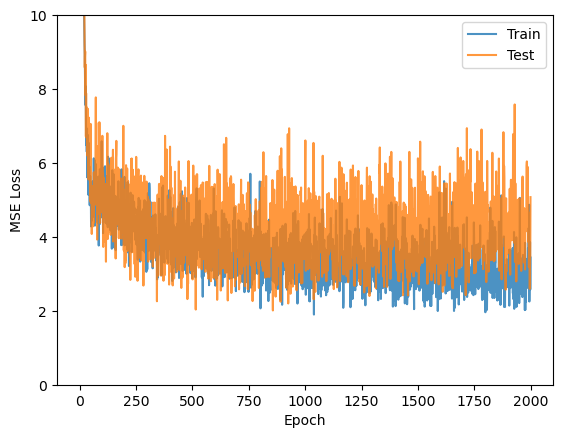

In [13]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(test_loss_list,label='Test',alpha=0.8)

ax.set_ylim(0,10)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

plt.show()

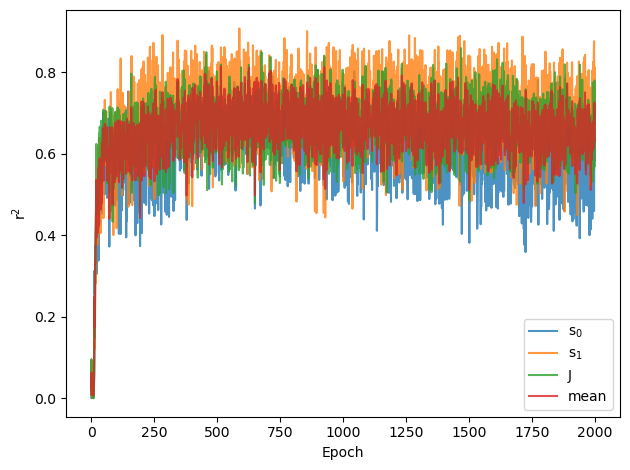

In [10]:
r2_array = np.array(r2_list)
labels = ['s$_0$', 's$_1$', 'J', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

## Plot the predicted vs. actuals

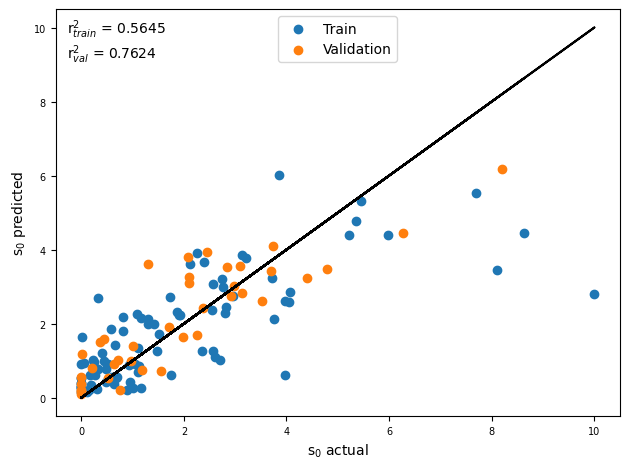

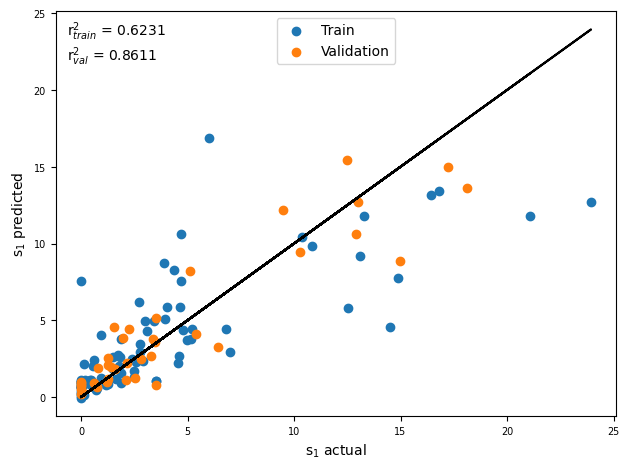

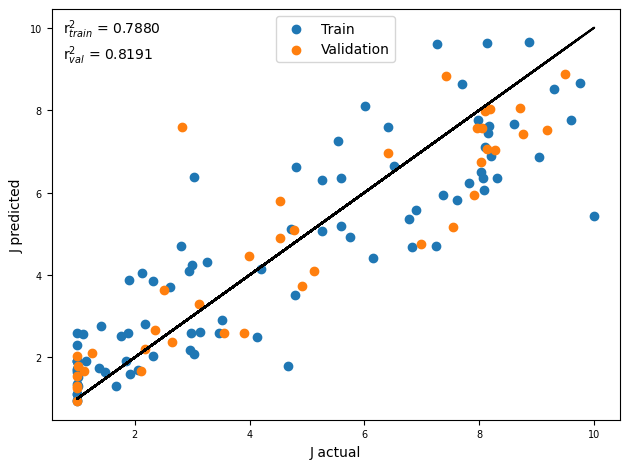

In [11]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['s$_0$', 's$_1$', 'J',]

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions,best_train_actuals,
                     best_val_predictions, best_val_actuals,i,label)
    ax.tick_params(axis='both', labelsize=7)
    plt.tight_layout()